In [20]:
import pandas as pd
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from mlflow.models.signature import infer_signature
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# ----------------------
# Step 1: Load Data
# ----------------------
data_path = "../data/processed/feature_engineered_data.csv"  # Adjust path if needed
df = pd.read_csv(data_path)

In [5]:
# ----------------------
# Step 2: Separate features and target
# ----------------------
target_col = "readmitted_30"
X = df.drop(columns=[target_col])
y = df[target_col]

In [6]:
# ----------------------
# Step 3: Identify categorical columns (object dtype)
# ----------------------
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

print(f"Categorical columns to encode: {cat_cols}")

Categorical columns to encode: ['gender', 'diag_1', 'diag_2', 'diag_3', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'diag_1_category', 'diag_2_category', 'diag_3_category']


In [7]:
# ----------------------
# Step 4: One-hot encode categorical columns
# ----------------------
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

In [8]:
# Clean column names (optional, recommended for XGBoost)
def clean_column_names(columns):
    return columns.str.replace(r"[\[\]\(\)<>\-]", "_", regex=True).str.replace("__", "_")

In [9]:
X_encoded.columns = clean_column_names(X_encoded.columns)

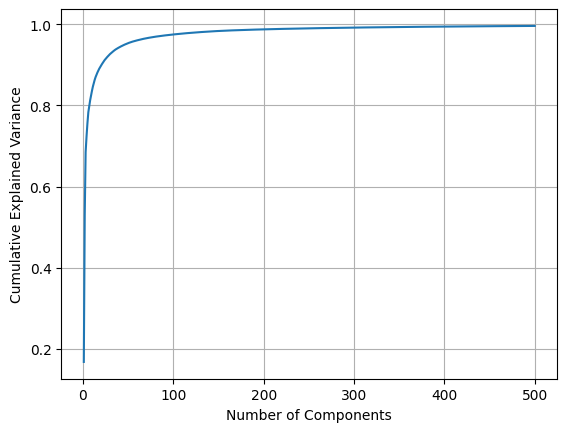

In [10]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

svd = TruncatedSVD(n_components=500, random_state=42)
svd.fit(X_encoded)

explained_variance = svd.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.plot(range(1, 501), cumulative_variance)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()


In [35]:
# Apply TruncatedSVD for dimensionality reduction
n_components = 50  # Adjust based on memory/performance trade-off
svd = TruncatedSVD(n_components=n_components, random_state=42)

X_reduced = svd.fit_transform(X_encoded)


In [36]:
print(f"Reduced feature shape: {X_reduced.shape}")

Reduced feature shape: (97108, 50)


In [37]:
# ----------------------
# Step 2: Train-Test Split
# ----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42, stratify=y
)

In [38]:
# ----------------------
# Step 6: Define models to train
# ----------------------
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    "XGBoost": xgb.XGBClassifier(eval_metric="logloss", random_state=42),
}

In [39]:
# ----------------------
# Step 7: Cross-validation results for comparison
# ----------------------
print("Cross-validation F1 scores:")

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1)
    print(f" - {name}: mean={scores.mean():.4f}, std={scores.std():.4f}")

Cross-validation F1 scores:
 - LogisticRegression: mean=0.0286, std=0.0051
 - RandomForest: mean=0.0027, std=0.0015
 - XGBoost: mean=0.0561, std=0.0067


In [40]:
mlflow.set_experiment("mediCareNet-readmission")

for name, model in models.items():
    with mlflow.start_run(run_name=name):
        # Train model
        model.fit(X_train, y_train)
        
        # Predict
        preds = model.predict(X_test)
        proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        
        # Metrics
        f1 = f1_score(y_test, preds)
        roc_auc = roc_auc_score(y_test, proba) if proba is not None else None
        
        # Infer model signature from training data
        signature = infer_signature(X_train, model.predict(X_train))
        
        # Log parameters and metrics
        mlflow.log_params(model.get_params())
        mlflow.log_metric("f1_score", f1)
        if roc_auc is not None:
            mlflow.log_metric("roc_auc", roc_auc)
        
        # Log model with signature and input example (first 5 rows of train)
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="model",
            signature=signature,
            input_example=X_train[:5]
        )
        
        print(f"✅ {name} trained and logged with signature.")
        print(f"   F1 Score: {f1:.4f}", f"ROC-AUC: {roc_auc:.4f}" if roc_auc else "")

✅ LogisticRegression trained and logged with signature.
   F1 Score: 0.0305 ROC-AUC: 0.6512


✅ RandomForest trained and logged with signature.
   F1 Score: 0.0027 ROC-AUC: 0.6488


✅ XGBoost trained and logged with signature.
   F1 Score: 0.0569 ROC-AUC: 0.6134


In [41]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Models to tune
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42),
}

# Parameter distributions for RandomizedSearchCV
param_distributions = {
    "LogisticRegression": {
        "C": uniform(loc=0.01, scale=10),          # Regularization strength
        "penalty": ["l2"],                         # L1 requires solver='liblinear', so keep L2 for simplicity
        "solver": ["lbfgs", "saga"],
        "class_weight": [None, "balanced"]
    },
    "RandomForest": {
        "n_estimators": randint(50, 300),
        "max_depth": randint(3, 20),
        "min_samples_split": randint(2, 10),
        "min_samples_leaf": randint(1, 5),
        "bootstrap": [True, False],
        "class_weight": [None, "balanced"]
    },
    "XGBoost": {
        "n_estimators": randint(50, 300),
        "max_depth": randint(3, 20),
        "learning_rate": uniform(0.01, 0.3),
        "subsample": uniform(0.6, 0.4),
        "colsample_bytree": uniform(0.6, 0.4),
        "gamma": uniform(0, 5),
        "reg_alpha": uniform(0, 1),
        "reg_lambda": uniform(0, 1),
    }
}

# Number of parameter settings to sample
n_iter_search = 20

# Perform tuning for each model
for name, model in models.items():
    print(f"Hyperparameter tuning for {name}...")
    param_dist = param_distributions[name]
    
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=n_iter_search,
        scoring="f1",
        cv=3,
        verbose=2,
        random_state=42,
        n_jobs=-1,
    )
    
    random_search.fit(X_train, y_train)
    
    print(f"Best params for {name}: {random_search.best_params_}")
    print(f"Best CV F1 score for {name}: {random_search.best_score_:.4f}")
    
    # Update the model in dict with best estimator
    models[name] = random_search.best_estimator_


Hyperparameter tuning for LogisticRegression...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params for LogisticRegression: {'C': np.float64(2.9314464853521813), 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV F1 score for LogisticRegression: 0.2632
Hyperparameter tuning for RandomForest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params for RandomForest: {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 237}
Best CV F1 score for RandomForest: 0.2678
Hyperparameter tuning for XGBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\HOME\Downloads\MediCareNet\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:17:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best params for XGBoost: {'colsample_bytree': np.float64(0.9214688307596458), 'gamma': np.float64(0.9328502944301792), 'learning_rate': np.float64(0.2777676995469933), 'max_depth': 13, 'n_estimators': 177, 'reg_alpha': np.float64(0.8074401551640625), 'reg_lambda': np.float64(0.8960912999234932), 'subsample': np.float64(0.7272013899887455)}
Best CV F1 score for XGBoost: 0.0602


In [42]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

print("Test set performance of tuned models:")

for name, model in models.items():
    # Predict on test set
    preds = model.predict(X_test)
    
    # Accuracy
    acc = accuracy_score(y_test, preds)
    
    # F1 Score
    f1 = f1_score(y_test, preds)
    
    # ROC-AUC (if probability available)
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, proba)
    else:
        roc_auc = None
    
    print(f"{name}:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    if roc_auc is not None:
        print(f"  ROC-AUC: {roc_auc:.4f}")
    print()


Test set performance of tuned models:
LogisticRegression:
  Accuracy: 0.6497
  F1 Score: 0.2695
  ROC-AUC: 0.6529

RandomForest:
  Accuracy: 0.6695
  F1 Score: 0.2679
  ROC-AUC: 0.6561

XGBoost:
  Accuracy: 0.8801
  F1 Score: 0.0635
  ROC-AUC: 0.6043



In [ ]:
# Calculate scale_pos_weight
neg_count = sum(y_train == 0)
pos_count = sum(y_train == 1)
scale_pos_weight = neg_count / pos_count

# Create XGBoost with scale_pos_weight
xgb_model = xgb.XGBClassifier(
    eval_metric="logloss",
    random_state=42,
    scale_pos_weight=scale_pos_weight,
)

# Fit and evaluate as before
xgb_model.fit(X_train, y_train)
preds = xgb_model.predict(X_test)
proba = xgb_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import f1_score, roc_auc_score
f1 = f1_score(y_test, preds)
roc_auc = roc_auc_score(y_test, proba)

print(f"F1 Score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")


c:\Users\HOME\Downloads\MediCareNet\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.2338, ROC-AUC: 0.6088


In [47]:
from sklearn.metrics import f1_score

best_threshold = 0.5
best_f1 = 0

thresholds = [i * 0.01 for i in range(1, 100)]  # 0.01 to 0.99

for threshold in thresholds:
    preds = (proba >= threshold).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best threshold: {best_threshold:.2f} with F1: {best_f1:.4f}")

Best threshold: 0.47 with F1: 0.2406


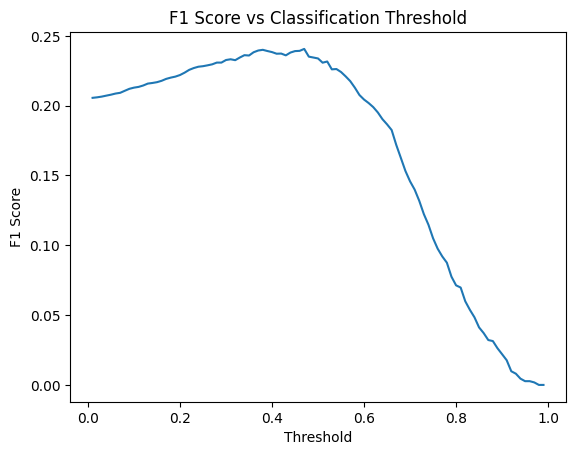

In [48]:
import matplotlib.pyplot as plt

f1_scores = []

for threshold in thresholds:
    preds = (proba >= threshold).astype(int)
    f1_scores.append(f1_score(y_test, preds))

plt.plot(thresholds, f1_scores)
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Classification Threshold")
plt.show()


In [50]:
from sklearn.metrics import f1_score, roc_auc_score, classification_report

mlflow.set_experiment("mediCareNet-readmission")

for name, model in models.items():
    with mlflow.start_run(run_name=name):
        model.fit(X_train, y_train)
        
        # Predict probabilities if available
        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(X_test)[:, 1]
            
            # Tune threshold for best F1
            thresholds = np.linspace(0.01, 0.99, 99)
            f1_scores = []
            for t in thresholds:
                preds = (proba >= t).astype(int)
                f1_scores.append(f1_score(y_test, preds))
            
            best_idx = np.argmax(f1_scores)
            best_threshold = thresholds[best_idx]
            best_f1 = f1_scores[best_idx]
            
            # Use best threshold for final preds
            final_preds = (proba >= best_threshold).astype(int)
            
            roc_auc = roc_auc_score(y_test, proba)
            
        else:
            # For models without predict_proba
            final_preds = model.predict(X_test)
            best_threshold = 0.5  # default
            best_f1 = f1_score(y_test, final_preds)
            roc_auc = None
        
        # Log parameters and metrics including best threshold
        signature = infer_signature(X_train, model.predict(X_train))
        mlflow.log_params(model.get_params())
        mlflow.log_metric("f1_score", best_f1)
        mlflow.log_metric("best_threshold", best_threshold)
        if roc_auc is not None:
            mlflow.log_metric("roc_auc", roc_auc)
        
        # Log model with signature and example
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="model",
            signature=signature,
            input_example=X_train[:5]
        )
        
        print(f"✅ {name} trained and logged with adaptive threshold {best_threshold:.2f}")
        print(f"   Best F1 Score: {best_f1:.4f}")
        if roc_auc is not None:
            print(f"   ROC-AUC: {roc_auc:.4f}")
        print(classification_report(y_test, final_preds))


✅ LogisticRegression trained and logged with adaptive threshold 0.54
   Best F1 Score: 0.2713
   ROC-AUC: 0.6529
              precision    recall  f1-score   support

           0       0.91      0.76      0.83     17197
           1       0.19      0.45      0.27      2225

    accuracy                           0.72     19422
   macro avg       0.55      0.60      0.55     19422
weighted avg       0.83      0.72      0.76     19422



✅ RandomForest trained and logged with adaptive threshold 0.51
   Best F1 Score: 0.2718
   ROC-AUC: 0.6561
              precision    recall  f1-score   support

           0       0.92      0.73      0.81     17197
           1       0.19      0.49      0.27      2225

    accuracy                           0.70     19422
   macro avg       0.55      0.61      0.54     19422
weighted avg       0.83      0.70      0.75     19422



c:\Users\HOME\Downloads\MediCareNet\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [15:05:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ XGBoost trained and logged with adaptive threshold 0.06
   Best F1 Score: 0.2341
   ROC-AUC: 0.6043
              precision    recall  f1-score   support

           0       0.91      0.71      0.80     17197
           1       0.16      0.43      0.23      2225

    accuracy                           0.68     19422
   macro avg       0.53      0.57      0.52     19422
weighted avg       0.82      0.68      0.73     19422

